In the previous exercises we applied cuts on various quantities embedded in the muon object without understanding what they were or why we were imposing the suggested requirements. In this exercise, we will build on the discussion in the introduction and the practice with the nanoAOD in the previous exercise to analyze the main properties and quality variables of muon tracks and how they can be used to identify muons from different sources. We will use the following NANOAODSIM files, containing simulated Drell–Yan, top-pair, and QCD multijet events:
* DYJetsToMuMu_M-50_TuneCP5_14TeV-madgraphMLM-pythia8.root
* TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8.root
* QCD_Pt-20toInf_MuEnrichedPt15_TuneCP5_13TeV_pythia8.root

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot_methods

# Step 1: Retrive and plot some variables
We will consider muons satisfying some very basic criteria:

* pT > 20 GeV
* |η| < 2.4, i.e. within the tracker acceptance 
* the muon must have an inner-tracker track
<br>

We will also retrieve and select the primary proton-proton vertices with some very basic requirements:

To begin, we can creat a few lists of file names, variable names and muon flavor to loop over those variables and plot histograms

In [16]:
filenames= ['DYJetsToMuMu_M-50_TuneCP5_14TeV-madgraphMLM-pythia8.root', 'TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8.root', 'QCD_Pt-20toInf_MuEnrichedPt15_TuneCP5_13TeV_pythia8.root']
variables= ['muon_pt', 'muon_eta', 'muon_isglobal', 'muon_istracker', 'muon_nstations', 'muon_ntrackerlayers', 'muon_dxy', 'muon_pfreliso04_all', 'muon_tkreliso']
muonid= ['muon_looseid', 'muon_mediumid', 'muon_tightid', 'muon_softid', 'muon_highptid']
muonflavs= ['prompt', 'tau', 'lf', 'fake']
bins=[20, 25, 2, 2, 6, 25, 40, 30, 30]
binrange=[[0,100], [-2.5, 2.5], [-0.5, 1.5], [-0.5, 1.5], [-0.5, 5.5], [-0.5, 24.5], [-0.10, 0.11], [0, 0.3], [0, 0.3]]

In [17]:
index=[0,1,2]
n=len(filenames)
file=[None]*n
muon=[None]*n
muon_genpartflav=[None]*n
npvsgood=[None]*n

In [4]:
for filename, idx in zip(filenames, index):
    #file[idx]=uproot.open(f'~/Downloads/{filename}')['Events']
    file[idx]=uproot.open(f'/cms/store/user/hats/Muon/{filename}')['Events']

for idx in index:
    muon[idx]=ak.JaggedArray.zip(muon_pt=file[idx].array(['Muon_pt']), muon_eta= file[idx].array(['Muon_eta']), muon_phi= file[idx].array(['Muon_phi']),
                        muon_isglobal= file[idx].array(['Muon_isGlobal']), muon_istracker= file[idx].array(['Muon_isTracker']),
                        muon_nstations= file[idx].array(['Muon_nStations']),
                        muon_ntrackerlayers= file[idx].array(['Muon_nTrackerLayers']),
                        muon_dxy=file[idx].array(['Muon_dxy']),
                        muon_pfreliso04_all= file[idx].array(['Muon_pfRelIso04_all']), 
                        muon_tkreliso= file[idx].array(['Muon_tkRelIso']),
                        muon_looseid= file[idx].array(['Muon_looseId']), 
                        muon_mediumid= file[idx].array(['Muon_mediumId']), 
                        muon_tightid= file[idx].array(['Muon_tightId']), 
                        muon_softid= file[idx].array(['Muon_softId']), 
                        muon_highptid= file[idx].array(['Muon_highPtId']),
                        pv_npvs= file[idx].array(['PV_npvs'])
                        )
    muon_genpartflav[idx]=file[idx].array(['Muon_genPartFlav'])
    npvsgood[idx]= file[idx].array(['PV_npvsGood'])
    

In order to proceed, each event must have at least one good vertex(selection:!isFake && ndof > 4 && abs(z) <= 24 && position.Rho <= 2), this information is stored in PV_npvsGood 

So every event have at lest one good vertex

To better understand the selection criteria, it is useful to classify each muon according to how it was produced:

* prompt, i.e. from the decay of a W or Z boson or from a τ lepton produced in the hard proton-proton interaction
* heavy flavor decay, i.e. from the decay of a b-quark or c-quark hadron
* light flavor decay, i.e. from the decay of a light-quark hadron, such as a pion or a kaon
* fake muons, such as punch-through or matching of random tracks and muon segments.

In nanoAOD file, the above information is stored in Muon_genPartFlav, here is its description:<br>
Flavour of genParticle for MC matching to status==1 muons: 1 = prompt muon (including gamma*->mu mu), 15 = muon from prompt tau, 5 = muon from b, 4 = muon from c, 3 = muon from light or unknown, 0 = unmatched <br>

These are some possible variables that we will investigate:<br>
whether the muon is a global muon, i.e. it was reconstructed with a combined fit of tracker and muon chambers measurements
* Muon_isGlobal

whether the muon is a tracker muon, i.e. it was identified by geometrically matching an inner track with segments in the muon chambers
* Muon_isTracker

Number of muon stations with matched segments
* Muon_nStations

Number of hits in the tracker layers
* Muon_nTrackerLayers

Transverse impact parameter of the track with respect to the vertex from which the muon originated
* Muon_dxy

PF-based combined relative isolation, Δβ-corrected for pileup
* Muon_pfRelIso04_all

Tracker-based relative isolation
* Muon_tkRelIso

Let's plot them 

In [6]:
diclist=[]
for idx in index:
    muon_mask=(muon[idx].muon_pt>20)& (abs(muon[idx].muon_eta)<2.4)
    dic={}
    for flav, type in zip([1, 15 , 3, 0], muonflavs):
        muon_mask_all= muon_mask& (muon_genpartflav[idx]==flav)
        event_mask= npvsgood[idx]>0 #at least one good primary vertex
        for var in variables:
            dic[f'{var}_{type}']=(muon[idx])[f'{var}'][muon_mask_all][event_mask]
        for id in muonid:        
            id_mask_combined=muon_mask_all& (((muon[idx])[f'{id}'])!=0)
            dic[f'{id}_{type}_pt']=(muon[idx])['muon_pt'][id_mask_combined][event_mask]
    
    muon_mask_tightid=muon_mask& (muon[idx].muon_tightid!=0)
    muon_mask_tightid_pfreliso04_all=muon_mask_tightid& (muon[idx].muon_pfreliso04_all<0.15)
    dic['npvs_muon_mask']=((muon[idx].pv_npvs)[muon_mask])[event_mask]
    dic['npvs_muon_mask_tightid']=(muon[idx].pv_npvs)[muon_mask_tightid][event_mask]
    dic['npvs_muon_mask_tightid_pfreliso04_all']=(muon[idx].pv_npvs)[muon_mask_tightid_pfreliso04_all][event_mask]
    diclist.append(dic)

In [37]:
diclist

[{'muon_pt_prompt': <JaggedArray [[28.913345] [] [52.494305 40.533558] ... [54.169434 51.1125] [50.2459 38.491104] [108.90053 52.06664]] at 0x7fc5410bad90>,
  'muon_eta_prompt': <JaggedArray [[0.38287354] [] [0.57702637 0.4537964] ... [-0.49017334 -1.6101074] [-0.125 -0.770874] [0.7303467 -0.050605774]] at 0x7fc5410bac10>,
  'muon_isglobal_prompt': <JaggedArray [[True] [] [True True] ... [True True] [True True] [True True]] at 0x7fc5410ba790>,
  'muon_istracker_prompt': <JaggedArray [[True] [] [True True] ... [True True] [True True] [True True]] at 0x7fc5410bae90>,
  'muon_nstations_prompt': <JaggedArray [[3] [] [3 3] ... [4 3] [4 3] [4 4]] at 0x7fc5410baa10>,
  'muon_ntrackerlayers_prompt': <JaggedArray [[14] [] [14 14] ... [12 14] [12 13] [12 13]] at 0x7fc5410ba710>,
  'muon_dxy_prompt': <JaggedArray [[-0.00026249886] [] [0.0003182888 0.00075769424] ... [-0.00065135956 0.0015821457] [8.4519386e-05 -2.5942922e-05] [0.00047445297 0.00058317184]] at 0x7fc5410ba7d0>,
  'muon_pfreliso04_a

In [14]:
combined_variables={}
for type in muonflavs:
        for var in variables:
            combined_variables[f'{var}_{type}']=np.concatenate((diclist[0][f'{var}_{type}'].flatten(), diclist[1][f'{var}_{type}'].flatten(), diclist[2][f'{var}_{type}'].flatten()))
        for id in muonid:
            combined_variables[f'{id}_{type}_pt']=np.concatenate((diclist[0][f'{id}_{type}_pt'].flatten(), diclist[1][f'{id}_{type}_pt'].flatten(), diclist[2][f'{id}_{type}_pt'].flatten()))
for name in ['npvs_muon_mask','npvs_muon_mask_tightid','npvs_muon_mask_tightid_pfreliso04_all']:
    combined_variables[name]=np.concatenate((diclist[0][name].flatten(), diclist[1][name].flatten(), diclist[2][name].flatten()))

In [426]:
combined_variables


{'muon_pt_prompt': array([28.913345, 52.494305, 40.533558, ..., 38.603867, 27.602608,
        21.03481 ], dtype=float32),
 'muon_eta_prompt': array([ 0.38287354,  0.57702637,  0.4537964 , ...,  1.4829102 ,
         0.3887329 , -0.23077393], dtype=float32),
 'muon_isglobal_prompt': array([ True,  True,  True, ...,  True,  True,  True]),
 'muon_istracker_prompt': array([ True,  True,  True, ...,  True,  True,  True]),
 'muon_nstations_prompt': array([3, 3, 3, ..., 4, 3, 3], dtype=int32),
 'muon_ntrackerlayers_prompt': array([14, 14, 14, ..., 14, 10, 12], dtype=int32),
 'muon_dxy_prompt': array([-0.0002625 ,  0.00031829,  0.00075769, ..., -0.00030994,
        -0.00048876,  0.00217438], dtype=float32),
 'muon_pfreliso04_all_prompt': array([0.        , 0.02316564, 0.09689394, ..., 0.        , 0.14940117,
        0.11222462], dtype=float32),
 'muon_tkreliso_prompt': array([0.        , 0.        , 0.08789062, ..., 0.10839844, 0.359375  ,
        0.84375   ], dtype=float32),
 'muon_looseid_pro

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


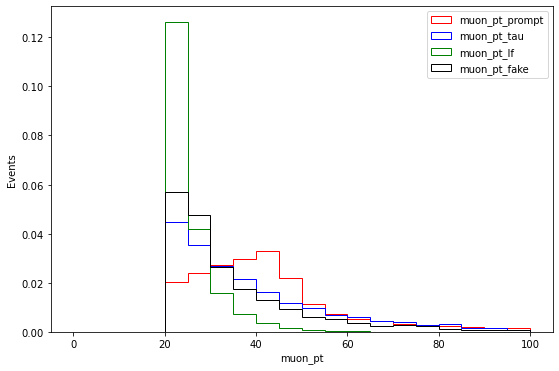

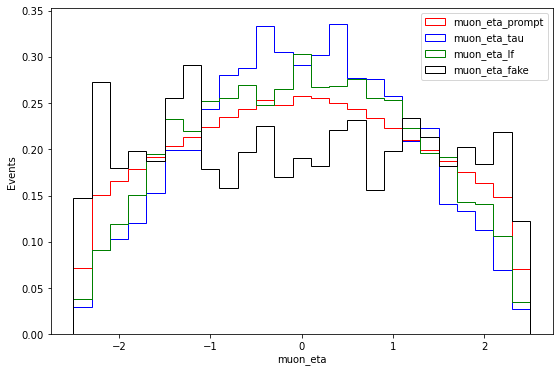

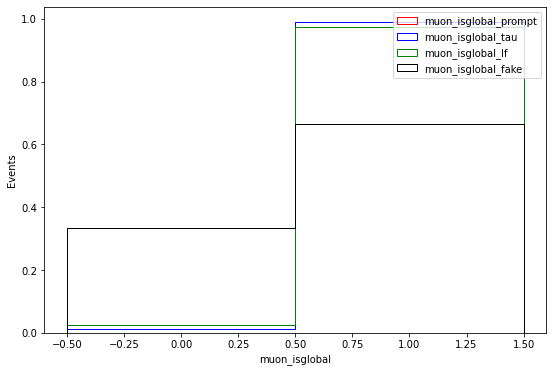

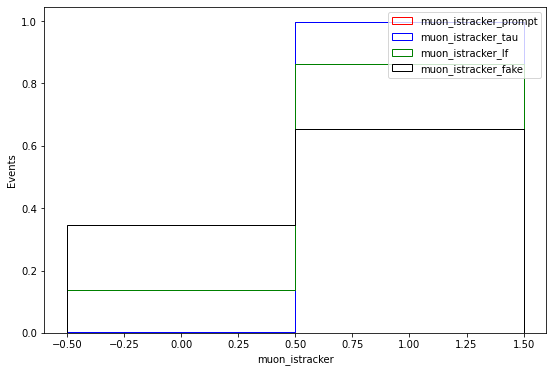

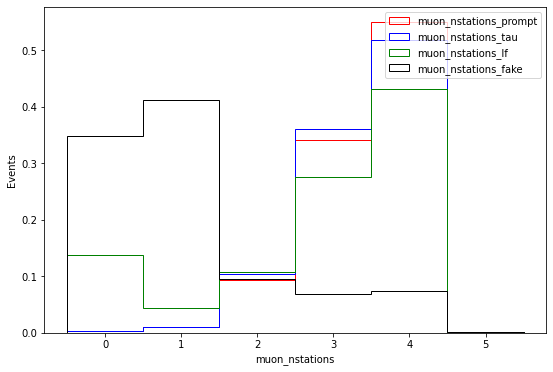

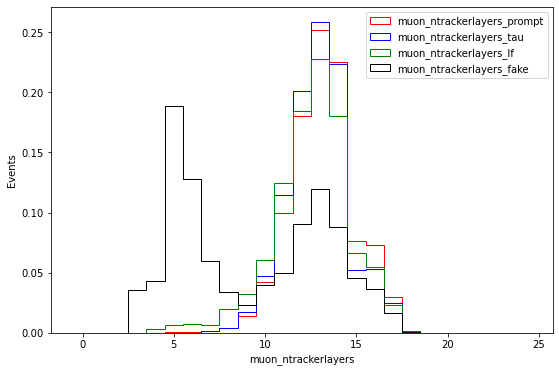

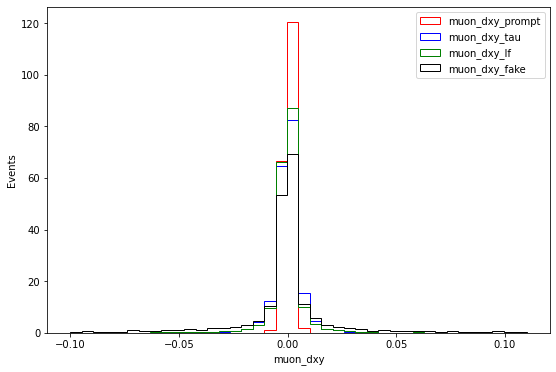

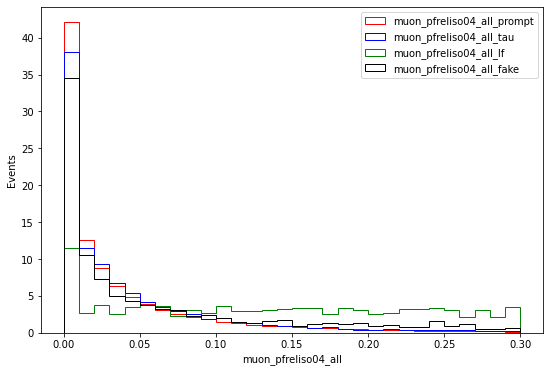

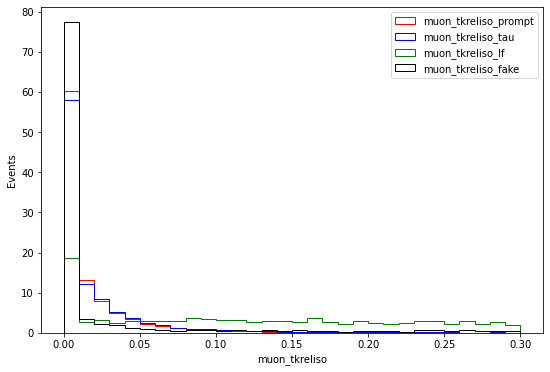

In [18]:
for var, bin, binrange in zip(variables, bins, binrange):
    plt.figure(figsize=(9,6))
    for type, color in zip(muonflavs, ['red', 'blue', 'green', 'black']):
        plt.hist((combined_variables[f'{var}_{type}']), bins=bin, range=binrange, density=True, histtype='step', linewidth=2, color=f'{color}', label=f'{var}_{type}')
    plt.legend()
    plt.xlabel(f'{var}')
    plt.ylabel('Events')
    #plt.yscale('log')       

**Questions 1**:
* What types of muons would you expect from each sample?
* For each variable, overlay the histograms from different sources. Can you explain the differences you observe?
* Explain the differences in the number of matched muon stations, number of hit in the tracker layers and isolation variables.
* By comparing the various distributions, could you come up with a possible set of cuts to isolate each source of muons?

Answer:
1. Prompt from drell yan sample. Top pair will contribute to prompt (muons from W decay), heavy flavor (muons from b-hadron decays). QCD mainly contribute to light flavor and fake.
1. Different decay mode have different kinematic features.


# Step 2: Standard muon definitions in CMS
The CMS Muon Physics Object Group (MUO POG) takes care of everything that concerns muon reconstruction, identification, high-level triggering, performance evaluation and monitoring, corrections, use in physics analysis, etc. Among other tasks, it develops and maintains a number of standard identification and isolation criteria, which are broadly used in analysis across all CMS. The full list of official definitions can be found on this [TWiki page](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideMuonIdRun2). Here you can find a summary of the most common criteria. These definitions are conveniently implemented as selectors for reco::Muon objects in the [MuonSelectors](https://github.com/cms-sw/cmssw/blob/master/DataFormats/MuonReco/interface/MuonSelectors.h) class, as well as functions in the pat::Muon class.

* *Loose Muons*
```c++
bool pat::Muon::isLooseMuon() 
bool muon::isLooseMuon(const reco::Muon& muon) {
    return muon.isPFMuon() && (muon.isGlobalMuon() || muon.isTrackerMuon());
}
```

* *Medium Muons*
```c++
bool pat::Muon::isMediumMuon() 
bool muon::isMediumMuon(const reco::Muon& muon) {
    if( !( isLooseMuon(muon) && muon.innerTrack()->validFraction()>0.8 )) return false; 

    bool goodGlb = muon.isGlobalMuon() && 
        muon.globalTrack()->normalizedChi2()<3. && 
        muon.combinedQuality().chi2LocalPosition<12. && 
        muon.combinedQuality().trkKink<20.; 

    return (segmentCompatibility(muon) > (goodGlb ? 0.303 : 0.451)); 
}
```
 
* *Tight Muons*
```c++
bool pat::Muon::isTightMuon(const reco::Vertex& vtx) 
bool muon::isTightMuon(const reco::Muon& muon, const reco::Vertex& vtx) {
    if(!muon.isPFMuon() || !muon.isGlobalMuon()) return false;
    bool muID = muon.isGlobalMuon() && muon.globalTrack()->normalizedChi2()<10. && muon.globalTrack()->hitPattern().numberOfValidMuonHits()>0 && muon.numberOfMatchedStations()>1;  
    bool hits = muon.innerTrack()->hitPattern().trackerLayersWithMeasurement()>5 && muon.innerTrack()->hitPattern().numberOfValidPixelHits()>0; 
    bool ip = fabs(muon.muonBestTrack()->dxy(vtx.position()))<0.2 && fabs(muon.muonBestTrack()->dz(vtx.position()))<0.5;
  
    return muID && hits && ip;
} 
```

* *Soft Muons* 
```c++ 
bool pat::Muon::isSoftMuon(const reco::Vertex& vtx) 
bool muon::isSoftMuon(const reco::Muon& muon, const reco::Vertex& vtx) {
    bool muID = muon::isGoodMuon(muon, TMOneStationTight);
    if(!muID) return false;
  
    bool layers = muon.innerTrack()->hitPattern().trackerLayersWithMeasurement()>5 &&
        muon.innerTrack()->hitPattern().pixelLayersWithMeasurement()>0;
    bool ishighq = muon.innerTrack()->quality(reco::Track::highPurity); 
    bool ip = fabs(muon.innerTrack()->dxy(vtx.position()))<0.3 && fabs(muon.innerTrack()->dz(vtx.position()))<20.;
  
    return layers && ip && ishighq;
}
```

* *HighPt Muons* 

```c++ 
bool pat::Muon::isHighPtMuon(const reco::Vertex& vtx) 
bool muon::isHighPtMuon(const reco::Muon& muon, const reco::Vertex& vtx){
    bool muID = muon.isGlobalMuon() && muon.globalTrack()->hitPattern().numberOfValidMuonHits()>0 &(muon.numberOfMatchedStations()>1);
    if(!muID) return false;

    bool hits = muon.innerTrack()->hitPattern().trackerLayersWithMeasurement()>5 &&
        muon.innerTrack()->hitPattern().numberOfValidPixelHits()>0; 
    bool momQuality = muon.tunePMuonBestTrack()->ptError()/muon.tunePMuonBestTrack()->pt()<0.3;
    bool ip = fabs(muon.innerTrack()->dxy(vtx.position()))<0.2 && fabs(muon.innerTrack()->dz(vtx.position()))<0.5;
  
  return muID && hits && momQuality && ip;
}
```


**Questions 2**:
* Given the implementation of the functions above, can you guess which types of muons each selection is meant to address, and why?
* The HighPt muon definition is very similar to the Tight muon one, but it adds a requirement on the transverse momentum resolution, σ(pT)/pT < 0.3. Can you find an explanation?
* Verify your guesses by adding these selections in your analyzer. Produce distributions for some variables (e.g. pT) for each muon category, after applying each of the selections above, one at a time.

Answer:
1. Loose, medium, tight ID, the tighter the ID, the more likely it is a muon. 
1. The high pt muon tend to have bad momentum resolution due to large energy loss from bremsstrahlung. By cutting on the the transeverse momentum resolution, we get muon with pt better measured.
1. See below

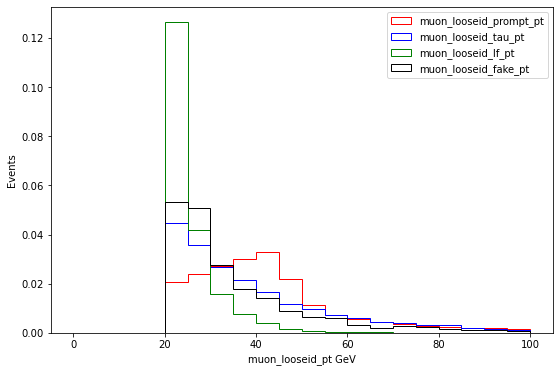

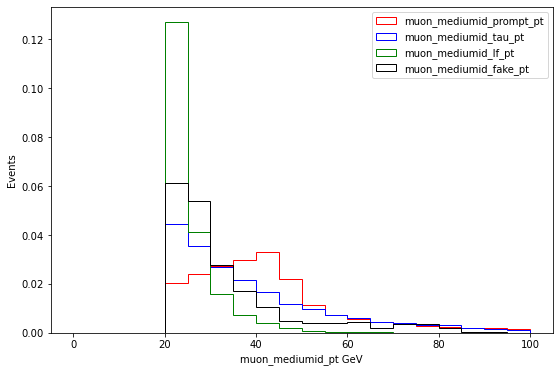

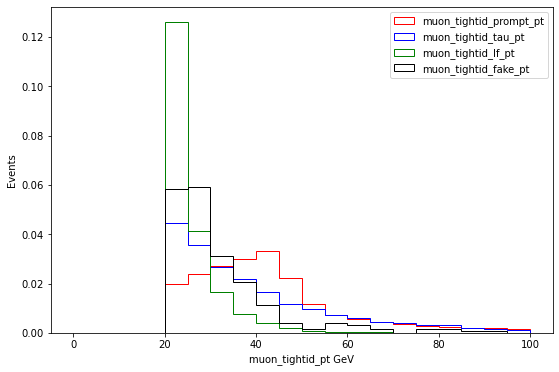

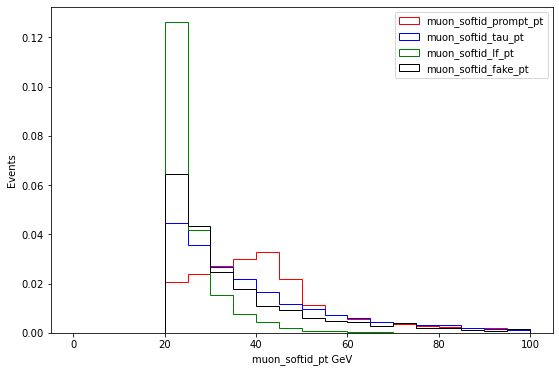

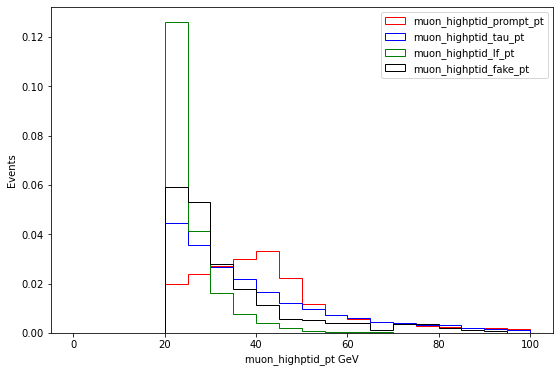

In [431]:
for id in muonid:
    plt.figure(figsize=(9,6))
    for type, color in zip(muonflavs, ['red', 'blue', 'green', 'black']):
        plt.hist((combined_variables[f'{id}_{type}_pt']), bins=20, range=[0, 100], density=True, histtype='step',linewidth=2, color=f'{color}', label=f'{id}_{type}_pt')
    plt.legend()
    plt.xlabel(f'{id}_pt GeV')
    plt.ylabel('Events')
    #plt.yscale('log')

# Step 3: Muon isolation

Let's now take a detailed look at the isolation variables mentioned at the beginning of Exercise 3. The most common muon isolation algorithm in CMS makes use of the PF candidates found in a region of &Delta;R < 0.4 around the muon track: 
```c++ 
mu->pfIsolationR04().sumChargedHadronPt   // pT sum of charged hadrons from the main primary vertex of the event 
mu->pfIsolationR04().sumNeutralHadronEt   // pT sum of neutral hadrons 
mu->pfIsolationR04().sumPhotonEt          // pT sum of photons 
```
In order to exploit the full-detector information, these variables can be combined in a single isolation variable: 
```c++ 
const reco::MuonPFIsolation &pfR04 = mu->pfIsolationR04();
double combRelIso = (pfR04.sumChargedHadronPt + pfR04.sumNeutralHadronEt + pfR04.sumPhotonE) / mu->pt();   // combined relative isolation 
```
The combined isolation turns out to perform better than the individual components separately in terms of efficiency _vs_ background rejection.<BR> 
Note that for neutral particles (photons and neutral hadrons) it is impossible to determine the vertex they originated from, since they don't have a track. Therefore neutral particles from pileup vertices contribute to the $P_T$ sum, and the performance of the combined isolation results to be strongly dependent on the pileup level. Corrections are available to mitigate such effect. The most common in CMS is called "&Delta;&beta; correction": it estimates the &Sigma;$P_T$ of neutral particles coming from pileup vertices using 
   1. the &Sigma;$P_T$ of charged particles from pileup vertices (mu->pfIsolationR04().sumPUPt), and 
   1. the ratio of neutral-to-charged particles expected in LHC proton-proton collisions. From simulation studies, this ratio results to be about 0.5. 

We can now define a &Delta;&beta;-corrected combined relative isolation_, less sensitive to the number of pileup vertices: 

```c++ 
const reco::MuonPFIsolation &pfR04 = mu->pfIsolationR04();
double corrCombRelIso = (pfR04.sumChargedHadronPt + std::max(0.0, pfR04.sumNeutralHadronEt + pfR04.sumPhotonEt - 0.5*pfR04.sumPUPt)) / mu->pt();
``` 

All the variables described above can be find in a minAOD file. In nanoAOD, the _&Delta;&beta;-corrected combined relative isolation is already calculated for you. It is stored as Muon_pfRelIso04_all. In addition, it is the only isolation variable in a region of &Delta;R < 0.4 around the muon track stored in nanoAOD currently.


**Questions 3**:
* In your analyzer, add distributions of the number of reconstructed primary vertices at different stages of the selection:
 1. for all muons,
 1. for muons passing the Tight ID,
 1. for muons passing the Tight ID plus the same cut on Muon_pfRelIso04_all, e.g. Muon_pfRelIso04_all < 0.15
* Aside from these pileup corrections, can you think of alternative isolation requirements that are not pileup-dependent? Try and implement one, then measure its efficiency vs number of reconstructed primary vertices.

Amswer:
1. See below.
1. Tracker based relatve isolation

Text(0, 0.5, 'Events')

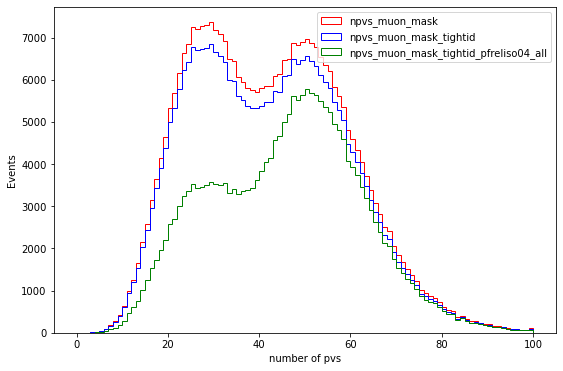

In [43]:
plt.figure(figsize=(9,6))
for name, color in zip(['npvs_muon_mask','npvs_muon_mask_tightid','npvs_muon_mask_tightid_pfreliso04_all'],['red', 'blue', 'green']):
    plt.hist((combined_variables[name]), bins=100, range=[0, 100], density=False, histtype='step',linewidth=2, color=f'{color}', label=name)
plt.legend()
plt.xlabel('number of pvs')
plt.ylabel('Events')
    